In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from arch import arch_model
import warnings
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, pacf, coint
import optuna, requests
from sklearn.metrics import mean_squared_error
import pandas as pd
from textblob import TextBlob
import plotly.subplots as sp
import plotly.graph_objects as go
import pingouin as pg
from scipy.stats import shapiro, boxcox, ttest_ind
from sklearn.preprocessing import PowerTransformer
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

class Analysis:


    def __init__(self, ticker_1, start='2020-01-01', end='2023-01-01', show=False, show_dist=False,):
        self.ticker_1 = ticker_1
        self.start = start
        self.end = end
        self.show_dist = show_dist
        # Download the stock data
        data = yf.download(self.ticker_1, start=self.start, end=self.end, progress=False)
        self.data = data
        data['daily return'] = data['Close'].pct_change()
        data['50 day MA'] = data['Close'].rolling(50).mean()
        data['200 day MA'] = data['Close'].rolling(200).mean()
        data['returns'] = data['Adj Close'].pct_change()
        data = data.reset_index()
        data.index = data['Date']
        self.data = data
        if show:
            plt.figure(figsize=(12, 6))
            plt.plot(data['Close'], label='Close Price', color='blue')
            plt.title(f'{ticker_1} Closing Prices')
            plt.xlabel('Date')
            plt.ylabel('Price in USD')
            plt.legend()
            plt.grid(True)
            plt.show()


        if show_dist:
            fig, ax = plt.subplots(2, 1, figsize=(12, 10))
            sns.histplot(data['daily return'].dropna(), bins=100, kde=True, color='green', ax=ax[0])
            ax[0].set_title(f'{ticker_1} Daily Return Distribution')
            ax[0].set_xlabel('Daily Return')
            ax[0].set_ylabel('Frequency')

            # Plot closing prices and moving averages on the second subplot
            ax[1].plot(data['Close'], label='Close Price', color='blue')
            ax[1].plot(data['50 day MA'], label='50 Day MA', color='orange')
            ax[1].plot(data['200 day MA'], label='200 Day MA', color='red')
            ax[1].set_title(f'{ticker_1} Closing Price and Moving Averages')
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Price in USD')
            ax[1].legend()
            ax[1].grid(True)

        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

    def _load_data(self, ticker):
        """Helper function to download stock data using yfinance."""
        try:
            self.data = yf.download(ticker, start=self.start, end=self.end, progress=False)
            if self.data.empty:
                print(f"No data found for {ticker} between {self.start} and {self.end}.")
                return None
            return self.data
        except Exception as e:
            print(f"Error loading data for {ticker}: {e}")
            return None


    def corr(self, *args, visual=True):
        """
        correlation bahut important hota hai, kyunki aap alag-alag stocks ke relationships ko analyze karte ho. For example, agar aap Apple ka comparison Microsoft ke stock ke saath karte ho, to aap dekh sakte ho ki dono stocks similar direction me move karte hain ya nahi.

        args: Visula, True (Default)
        """
        prices = pd.DataFrame()
        for ticker in args:
            data = yf.download(ticker, start=self.start, end=self.end, progress=False)
            prices[ticker] = data['Close']

        corr = prices.corr()
        if visual:
            sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=1, vmax=1)
            plt.title(f'Correlation between {", ".join(args)}')
            plt.show()


    def volatilityAnalysis(self, day=21, show_output=True):
        "Volatility Analysis is based on standard deviation"
        self.day = day
        self.data[f'{self.day} day analysis'] = self.data['daily return'].rolling(self.day).std()
        if show_output:
            plt.figure(figsize=(12, 6))
            plt.plot(self.data[f'{self.day} day analysis'], label='21 Day Volatility', color='red')
            plt.title(f'{self.ticker_1} Closing Price and 21-Day Volatility')
            plt.xlabel('Date')
            plt.ylabel('Price in USD / Volatility')
            plt.ylim([0, 0.1])  # Adjusting y-axis to make volatility more visible
            plt.legend()
            plt.grid(True)

            plt.show()
            plt.figure(figsize=(12, 6))

            plt.plot(self.data['Close'], label='Close Price', color='blue')
            plt.grid(True)
    


    def autocorrelationAnalysis(self, lag=21):
        """
        Autocorrelation ek stock ke current prices aur past prices ke beech ka relationship measure karta hai. Agar autocorrelation zyada ho, to iska matlab hai stock ka past data future ke movements ko predict karne me madad kar sakta hai.

        Agar early lags me zyada autocorrelation ho, to stock momentum ya mean reversion strategy ke liye acha candidate ho sakta hai.

        """
        plt.figure(figsize=(10, 6))
        plot_acf(self.data['daily return'].dropna(), lags=lag)
        plt.title('Autocorrelation analysis')
        plt.show()
    
    def seasonality_and_trend(self, sampling='M'):
        """
        Hum seasonal decomposition method ka use karenge, jo stock ki price ko 3 parts me divide karta hai: trend, seasonality, aur residuals.


        Trend:
        Yeh line aapko long-term trend batata hai, jo price ke overall movement ko smooth kar deta hai. Agar stock price overall upar ya neeche ja raha hai, aapko is trend line me clear direction dikhni chahiye.
        Example: Agar AAPL ka trend line consistent upward slope show kar raha hai, to iska matlab long-term trend bullish hai (price upar ja rahi hai).
        Seasonality:

        Seasonality ka matlab hai ki stock price har year ya month ke same time pe similar behavior dikha rahi hai. Yeh repeat patterns ko capture karta hai.
        Is graph me, aapko periodic (repeating) up-down patterns dikhne chahiye. Jaise ki, har saal ke kuch months me price thoda zyada girta ya badhta hai, to yeh seasonal effect ho sakta hai.
        Example: Agar aapko har December me price ka drop dikh raha hai, aur har April me rise, to yeh ek seasonal pattern ho sakta hai.
        Residuals:

        Residuals me woh part hota hai jo trend aur seasonality explain nahi kar sakte. Yeh unpredictable fluctuations ko capture karta hai.
        Is graph me agar aapko spikes ya sudden changes dikhte hain, to iska matlab hai ki price me kuch unpredictable events huye hain (jaise news events ya earnings announcements).
        Example: Agar residuals me ek high spike aata hai ek specific month me, aur us month me koi significant news aayi thi, to yeh us unpredictable event ko indicate karega.
        """
        data_monthly = self.data['Close'].resample(sampling).mean()
        plt.figure(figsize=(12, 6))
        decomposition = seasonal_decompose(data_monthly.dropna(), model='additive')
        decomposition.plot()
        plt.show()  



    def garch(self, horizon = 5):
        """
        GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model ka use karenge, jo stock ke volatility ko forecast karne ke liye advanced technique hai. Yeh model time-varying volatility ko account karta hai, jo simple rolling standard deviation se better hai.

        garch_fit.forecast(horizon=5) use karte ho, toh aap aane wale 5 time periods ke liye volatility forecast karte ho.

        Variance GARCH model ka key output hota hai, jo aane wale periods ke volatility ko represent karta hai.
        Jab aap garch_forecast.variance[-1:] likhte ho, aap GARCH forecasted variance ka last value access karte ho.
        Variance ka matlab hota hai price movement ki spread, aur yeh volatility ko square terms me represent karta hai.

        higher variance → higher volatility,
        


        """

        returns = self.data['daily return'].dropna()*100
        self.returns = returns
        #optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=20)
        print(f'Best params: {study.best_params}, Best AIC: {study.best_value}')
        print(study.best_params['p'])
        best_p = study.best_params['p']
        best_q = study.best_params['q']

        self.best_p = best_p
        self.best_q = best_q


        #earch
        earch_model = arch_model(returns, vol='EGARCH', p=1,q=1)
        earch_fit = earch_model.fit(disp='off')
        print(f"EGARCH AIC: {earch_fit.aic}")


        #testing GJR-GARCH
        gjr_garch = arch_model(returns ,vol='GARCH', p=1, q=1, o=1)
        gjr_garch_fit = gjr_garch.fit(disp='off')
        print(f"GJR-GARCH AIC: {gjr_garch_fit.aic}")
        
        #CROSSVAL
        train_size = int(len(returns)*0.8)
        train_data, test_data = returns[:train_size], returns[train_size:]

        self.train_size = train_size
        self.train_data = train_data
        self.test_data = test_data

        model = arch_model(train_data, vol='GARCH', p=best_p, q=best_q)
        model_fit = model.fit(disp='off')

        forecast = model_fit.forecast(horizon=horizon, reindex=False)
        predict_variance = forecast.variance.values[-1]
        actual_variance = np.var(test_data)
        print(model_fit.summary())
        print(f"Prected vairance: {predict_variance}, Actual variance: {actual_variance}")


        ##ljungbox

        residuals = model_fit.resid
        lb_test =acorr_ljungbox(residuals, lags=[10], return_df=True)
        print(lb_test)

        #optuna


    def objective(self , trail):
        p = trail.suggest_int('p', 1, 5)
        q = trail.suggest_int('q', 1, 5)

        model = arch_model(self.returns, vol='GARCH', p=p, q=q)
        model_fit = model.fit(disp='off')

        return model_fit.aic
    

    def backtest_Garch(self):
        model = arch_model(self.train_data, vol='GARCH', p=self.best_p, q=self.best_q)
        model_fit = model.fit(disp='off')
        forecasted_volatility = []
        actual_volatility = []

        for i in range(len(self.test_data)):
            train_until_now = self.returns[:self.train_size+i]
            model = arch_model(train_until_now, vol='GARCH', p=self.best_p, q=self.best_q)
            model_fit = model.fit(disp='off')

            forecast = model_fit.forecast(horizon=1)
            forecasted_volatility.append(forecast.variance.values[-1][0])
            actual_volatility.append(np.abs(self.test_data.iloc[i]))


        forecasted_volatility = np.array(forecasted_volatility)
        actual_volatility = np.array(actual_volatility)

        mse = mean_squared_error(actual_volatility, forecasted_volatility)
        print(f"Mean Squared error {mse}")

        correlation = np.corrcoef(actual_volatility, forecasted_volatility)[0, 1]
        print(f"Correlation between forecast and actual volatility: {correlation}")
        if correlation> 0.4:
            print(f"This technique may applicable for this {self.ticker_1}")

        else:
            print(f"This technique is not suitable for {self.ticker_1}, since your correlation is low")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test_data.index, forecasted_volatility, label='Forecasted Volatility', color='blue')
        plt.plot(self.test_data.index, actual_volatility, label='Actual Volatility', color='red')
        plt.title('Backtesting GARCH Model: Forecasted vs Actual Volatility')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()

    

    def sentiment_analysis(self, api="ee9d8860746346958e377e0635b1d9ad", show_output=True):

        

        self.api = api
        url = f'https://newsapi.org/v2/everything?q=stock market&apiKey={api}&pageSize=100'
        response = requests.get(url)
        data = response.json()
        
        # Fetch headlines
        headlines = [article['title'] for article in data['articles']]
        if len(headlines) == 0:
            raise ValueError("No headlines retrieved. Please check the API or query.")
        
        # Calculate sentiment for each headline
        sentiment_score = [TextBlob(headline).sentiment.polarity for headline in headlines]
        
        # Resample or expand sentiment_score to match the length of stock data
        # For simplicity, repeating the sentiment scores to match the data length
        sentiment_score_resampled = np.resize(sentiment_score, len(self.data))
        
        # Add the resampled sentiment score to the stock data
        self.data['sentiment'] = sentiment_score_resampled
        if show_output:
            # Plot the results
            fig = sp.make_subplots(rows=2, cols=1, subplot_titles=("Sentiment Distribution", "Stock Returns vs Sentiment"))

            # Plot sentiment distribution (histogram)
            fig.add_trace(
                go.Histogram(
                    x=sentiment_score,
                    nbinsx=20,
                    marker=dict(color='orange', line=dict(color='black', width=1)),
                    name='Sentiment Distribution'
                ),
                row=1, col=1
            )

            # Plot stock returns
            fig.add_trace(
                go.Scatter(
                    x=self.data['Date'],
                    y=self.data['returns'],  # Skipping the first value to match dimensions
                    mode='lines',
                    name='Stock Returns',
                    line=dict(color='blue')
                ),
                row=2, col=1
            )

            # Plot stock sentiment
            fig.add_trace(
                go.Scatter(
                    x=self.data['Date'],
                    y=self.data['sentiment'],  # Skipping the first value to match dimensions
                    mode='lines',
                    name='Stock Sentiment',
                    line=dict(color='orange', dash='dash')
                ),
                row=2, col=1
            )

            # Update layout
            fig.update_layout(
                height=800,
                width=1000,
                title_text="Sentiment Analysis and Stock Returns",
                template='plotly_white',
                showlegend=True
            )

            # Update axis titles
            fig.update_xaxes(title_text="Sentiment Polarity", row=1, col=1)
            fig.update_yaxes(title_text="Frequency", row=1, col=1)
            fig.update_xaxes(title_text="Date", row=2, col=1)
            fig.update_yaxes(title_text="Returns/Sentiment", row=2, col=1)

            # Show the plot
            fig.show()


    def corr_factors(self, *args):
        ''''''
        factors = [factor for factor in args if factor in self.data.columns]
        if len(factors)<2:
            raise ValueError("At least two parameters are required for correlation analysis")

        corr_matrix = self.data[factors].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.show()

    def partial_corr(self, dataa=None, x='returns', y='sentiment', covar='Volume'):
        '''
        Partial correlation helps in understanding the relationship between two variables while controlling for the effect of a third variable. For example, we might want to see how AAPL returns correlate with sentiment, controlling for volume.
        '''
        self.dataa = self.data if dataa is None else dataa
        partialcorr = pg.partial_corr(data=self.data, x=x, y=y, covar=covar)
        print(partialcorr)

    
    def grangerCausalityTest(self, dataa=None, lags=4, x='returns', y='sentiment'):
        '''# Correlation tells us about the relationship between variables but not causality (i.e., whether one causes the other). To test causality in time series data, we can use the Granger Causality Test.# Granger causality test tabhi sahi results dega jab aapka time series data stationary ho. 0.9 to 1.1

        params: *args: ['returns', 'Sentiment']
        '''
        self.dataa = self.data if dataa is None else dataa
        stabilty = adfuller(self.dataa.x.dropna())
        if stabilty[0]>1 and stabilty[1]>0.05:
            print(f"Cannot test grangercasuality since ADF stats:{stabilty[0]} with p-value of {stabilty[1]} is high")
        else:
            gc_test =grangercausalitytests(self.dataa[[x, y]], maxlag=lags)
            print(gc_test)

    def normality_test(self, dataa=None, with_relation='Close', transformation=False):
        dataa = self.data if dataa is None else dataa
        stats, p_val = shapiro(dataa[with_relation])
        
        if p_val > 0.05:
            print("Data is normally distributed")
        else:
            by_value = dataa[with_relation].skew()
            print(f"Skewed by {by_value}")
            print("Use some transformation")
        
        if transformation:
            # Apply transformations and handle boxcox correctly
            dataa['log'] = np.log1p(dataa[with_relation])  # log1p to handle zero values
            dataa['sqrt'] = np.sqrt(dataa[with_relation])
            
            # Ensure no negative values for boxcox
            if (dataa[with_relation] <= 0).any():
                print("Data contains non-positive values, applying a shift for BoxCox transformation.")
                dataa['boxcox'], lambda_val = boxcox(dataa[with_relation] + 1)  # Adding 1 to handle zero/negative values
            else:
                dataa['boxcox'], lambda_val = boxcox(dataa[with_relation])
            
            # Apply Yeo-Johnson transformation correctly
            yeo_transformer = PowerTransformer(method='yeo-johnson')
            yeo_transformered = yeo_transformer.fit_transform(dataa[with_relation].to_numpy().reshape(-1, 1))
            transformed_series = pd.Series(yeo_transformered.flatten())
            print("Yeo-Johnson skew", transformed_series.skew())
            
            print("After transformation, skewness results are as follows:")
            print(f"Log skewness: {dataa['log'].skew()}")
            print(f"Sqrt skewness: {dataa['sqrt'].skew()}")
            print(f"BoxCox skewness: {dataa['boxcox'].skew()}")

            # Plot the results
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))

            # Original Distribution
            sns.histplot(dataa[with_relation], kde=True, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title('Original Distribution')
            axes[0, 0].set_xlabel('Values')
            axes[0, 0].set_ylabel('Frequency')

            # Log Transformation Distribution
            sns.histplot(dataa['log'], kde=True, ax=axes[0, 1], color='green')
            axes[0, 1].set_title('Log Transformed Distribution')
            axes[0, 1].set_xlabel('Log Transformed Values')
            axes[0, 1].set_ylabel('Frequency')

            # Box-Cox Transformation Distribution
            sns.histplot(dataa['boxcox'], kde=True, ax=axes[1, 0], color='orange')
            axes[1, 0].set_title('Box-Cox Transformed Distribution')
            axes[1, 0].set_xlabel('Box-Cox Transformed Values')
            axes[1, 0].set_ylabel('Frequency')

            # Yeo-Johnson Transformation Distribution
            sns.histplot(transformed_series, kde=True, ax=axes[1, 1], color='red')
            axes[1, 1].set_title('Yeo-Johnson Transformed Distribution')
            axes[1, 1].set_xlabel('Yeo-Johnson Transformed Values')
            axes[1, 1].set_ylabel('Frequency')

            # Adjust the layout for better spacing
            plt.tight_layout()

            # Show the plot
            plt.show()



    def zscore_test(self, rolling =14):
        self.data['rolling_mean'] = self.data['Adj Close'].rolling(rolling).mean()
        self.data['rolling_std'] = self.data['Adj Close'].rolling(rolling).std()

        self.data['Z-score'] = (self.data['Adj Close'] - self.data['rolling_mean'])/self.data['rolling_std']

        plt.figure(figsize=(10, 6))
        plt.plot(self.data['Date'], self.data['Z-score'], label='Z-score')
        plt.axhline(2, color='red', linestyle='--', label='overbrought')
        plt.axvline(-2, color='green', linestyle='--', label='oversold')
        plt.title(f'Z-score of {self.ticker_1} stock price')



    def GaussianHMM(self, *tickers, components=2, n_iter=1000, analyze=False, multivar=False):
        """
        Perform HMM analysis (univariate or multivariate) on stock returns.
        
        :param components: Number of hidden states (default is 2).
        :param n_iter: Maximum number of iterations for HMM convergence.
        :param analyze: Whether to perform additional analysis on hidden regimes.
        :param multivar: If True, perform multivariate HMM analysis.
        :param args: Additional stock tickers for multivariate HMM.
        #### Hidden Markov Models (HMM) ek bohot powerful tool hai jo market ke hidden regimes ko detect karne ke liye use hota hai. Jaise aap market me directly nahi dekh sakte ki wo abhi "bullish" ya "bearish" hai, lekin HMM ki help se hum probabilistic states nikal sakte hain jo indirectly ye batate hain ki market kis state me hai
        """
        
        # Univariate HMM for a single stock
        if not multivar:
            if self.data is None:
                print("Ticker data is not loaded. Please provide a ticker.")
                return

            # Prepare the data for univariate HMM
            self.data = self.data.dropna(subset=['returns'])  # Drop NaN returns
            return_data = self.data['returns'].values.reshape(-1, 1)

            # Initialize and fit the HMM
            hmm_model = GaussianHMM(n_components=components, covariance_type='full', n_iter=n_iter)
            hmm_model.fit(return_data)

            # Predict hidden states
            hidden_states = hmm_model.predict(return_data)
            self.data['hidden_state'] = hidden_states  # Now lengths match

            # Plot hidden states on price data
            plt.figure(figsize=(10, 6))
            plt.plot(self.data.index, self.data['Adj Close'], label='Adjusted Close Price')
            for i in range(hmm_model.n_components):
                state = (self.data['hidden_state'] == i)
                plt.plot(self.data.index[state], self.data['Adj Close'][state], 'o', label=f'Regime {i + 1}', markersize=5)
            plt.legend()
            plt.show()

            # Perform regime analysis if requested
            if analyze:
                regime_stats = self.data.groupby('hidden_state')['returns'].agg(['mean', 'std', 'var', 'count'])
                print(regime_stats)

                # Plot returns with regime coloring
                plt.figure(figsize=(10, 6))
                plt.plot(self.data.index, self.data['returns'], label='Returns', alpha=0.5)
                for i in range(hmm_model.n_components):
                    state = (self.data['hidden_state'] == i)
                    plt.scatter(self.data.index[state], self.data['returns'][state], label=f'Regime {i + 1}', alpha=0.5)
                plt.title('Returns with Market Regimes')
                plt.xlabel('Date')
                plt.ylabel('Returns')
                plt.legend()
                plt.grid()
                plt.show()

        elif multivar:
            if not tickers:
                print("Please provide tickers for multivariate analysis.")
                return

            combined_data = pd.DataFrame()

            # Load data for each ticker and calculate returns
            for ticker in tickers:
                data = yf.download(ticker, start=self.start, end=self.end, progress=False)
                data['Adj Close'] = pd.to_numeric(data['Adj Close'], errors='coerce')
                combined_data[ticker] = data['Adj Close'].pct_change().dropna()

            # Combine returns for multivariate HMM
            return_data = np.column_stack([combined_data[ticker] for ticker in combined_data.columns])

            # Initialize and fit the multivariate HMM
            multivar_hmm = GaussianHMM(n_components=components, covariance_type='full', n_iter=n_iter)
            multivar_hmm.fit(return_data)

            # Predict hidden states
            hidden_states = multivar_hmm.predict(return_data)
            combined_data['hidden_state'] = hidden_states  # Assign hidden states to the combined data

            # Perform regime analysis if requested
            if analyze:
                # Calculate regime statistics for each regime
                regime_stats = combined_data.groupby('hidden_state').agg(['mean', 'std', 'var', 'count'])
                # print(regime_stats)

                # Plotting with Plotly
                dates = combined_data.index  # Assume all tickers have the same date index

                # Create Plotly figure
                fig = go.Figure()

                # Plot returns for each ticker
                for ticker in tickers:
                    returns = combined_data[ticker].values

                    # Plot the ticker's returns
                    fig.add_trace(go.Scatter(
                        x=dates,
                        y=returns,
                        mode='lines',
                        name=f'{ticker} Returns',
                        line=dict(width=2),
                        opacity=0.7
                    ))

                    # Plot hidden states (regimes) for each component
                    colors = ['green', 'red', 'purple', 'yellow', 'blue']  # Colors for regimes
                    for i in range(multivar_hmm.n_components):
                        state = (hidden_states == i)

                        # Plot the ticker's returns for each regime
                        fig.add_trace(go.Scatter(
                            x=dates[state],
                            y=returns[state],
                            mode='markers',
                            name=f'Regime {i + 1} ({ticker})',
                            marker=dict(color=colors[i % len(colors)], size=8),
                        ))

                # Add title and labels
                fig.update_layout(
                    title='Stock Returns with Hidden States (Multivariate)',
                    xaxis_title='Date',
                    yaxis_title='Returns',
                    legend_title='Legend',
                    template='plotly_white',
                    hovermode='x unified'
                )

                # Show figure
                fig.show()

        else:
            print("Multivariate HMM flag is not set.")




In [2]:
a = Analysis(ticker_1='HDFCBANK.NS')

a.GaussianHMM('ICICIBANK.NS', 'HDFCBANK.NS', components=2, n_iter=9000, multivar=True, analyze=True)



<Figure size 640x480 with 0 Axes>

Model is not converging.  Current: 4048.264314600495 is not greater than 4048.3149427513094. Delta is -0.05062815081464578


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class MAnalysis(Analysis):
    def __init__(self, ticker):
        super().__init__(ticker_1=ticker)
        self.data = self.data
        # print(self.data)

    def PCAnalysis(self, *args,data=None, components=2,  c='Adj Close'):
        '''
        Principal Components Analysis:
        params:
        *args: Can be numerical columns from the dataset.
        c: Column name to use for color coding (default: 'Adj Close').
        '''
        # Ensure the passed factors (column names) exist in self.data
        factors = [factor for factor in args if factor in self.data.columns]
        if not factors:
            raise ValueError("No valid factors (columns) were provided.")

        # Use self.data if no data is provided, otherwise use the provided data
        self.data = self.data if data is None else data

        # Scale the selected factors
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data[factors])
        self.scaled_data = scaled_data
        # Apply PCA
        pca = PCA(n_components=components)
        principle_components = pca.fit_transform(scaled_data)

        # Add the PCA components back to the DataFrame
        self.data['PCA1'] = principle_components[:, 0]
        self.data['PCA2'] = principle_components[:, 1]

        # Plot the PCA results
        plt.figure(figsize=(10, 6))
        plt.scatter(self.data['PCA1'], self.data['PCA2'], c=self.data[c], cmap='viridis')
        plt.colorbar(label=c)
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.show()

    def TSNEanalysis(self, components, relation_with='Adj Close'):
        tsne = TSNE(n_components=components)
        tsne_result = tsne.fit_transform(self.scaled_data)
        self.data['t-SNE1'] = tsne_result[:, 0]
        self.data['t-SNE2'] = tsne_result[:, 1]
        plt.figure(figsize=(10, 7))
        plt.scatter(self.data['t-SNE1'], self.data['t-SNE2'], c=self.data[relation_with], cmap='coolwarm')

        for i in range(0, len(self.data), 50):
            plt.text(self.data['t-SNE1'].iloc[i], self.data['t-SNE2'].iloc[i], 
            self.data['Date'].iloc[i].strftime('%Y-%m-%d'), fontsize=9)
                     

        plt.title(f't-SNE of {self.ticker_1} data with dated')
        plt.xlabel("t-SNE1")
        plt.ylabel("t-SNE2")
        plt.colorbar()
        plt.show()


    def emotional_checkup(self, days= 21):
        self.days = days
        valid_data = self.data[['returns']].dropna()

        self.volatilityAnalysis(self.days, show_output=False)
        self.sentiment_analysis(show_output=False)

        # KMeans clustering on the 'returns' column
        kmeans = KMeans(n_clusters=3)
        self.data['cluster'] = np.nan  # Initialize a cluster column with NaN

        # Apply KMeans only to non-NaN 'returns' data
        self.data.loc[valid_data.index, 'cluster'] = kmeans.fit_predict(valid_data)

        print("Cluster 0: stable and less volatile\nCluster 1: high volatile and high return\nCluster 2: negative return and high volatile")
        # Plotting clusters over time
        plt.figure(figsize=(10, 6))
        
        if 'date' in self.data.columns:
            x_vals = self.data['date']
        else:
            x_vals = self.data.index  # Use index if 'date' column doesn't exist

        # Loop through clusters and scatter plot each
        for cluster in self.data['cluster'].dropna().unique():
            cluster_data = self.data[self.data['cluster'] == cluster]
            plt.scatter(cluster_data.index, cluster_data['returns'], label=f'Cluster {int(cluster)}', alpha=0.6)
        
        plt.title(f"K-Means Clustering of {self.ticker_1} Data")
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.show()

        fig = go.Figure()

        # Loop through each cluster and add the data to the plot
        for cluster in self.data['cluster'].dropna().unique():
            cluster_data = self.data[self.data['cluster'] == cluster]

            # Add a scatter trace with hovertemplate to show the date
            fig.add_trace(go.Scatter(
                x=cluster_data[f'sentiment'],  # X-axis: Volatility (or other variable)
                y=cluster_data['returns'],  # Y-axis: Returns
                mode='markers',
                name=f'Cluster {int(cluster)}',
                opacity=0.6,
                marker=dict(size=8, line=dict(width=1)),
                
                # Customize hovertemplate to display Date, X, and Y values
                hovertemplate=
                '<b>Date</b>: %{text}<br>' +  # Display the date
                '<b>Volatility</b>: %{x}<br>' +
                '<b>Returns</b>: %{y}<extra></extra>',  # Extra prevents additional info from showing
                text=cluster_data['Date'].dt.strftime('%Y-%m-%d')  # Pass formatted dates as hover text
            ))

        # Update layout with titles and labels
        fig.update_layout(
            title=f"K-Means Clustering of Sentiment and returns ({self.ticker_1})",
            xaxis_title=f'sentiment',
            yaxis_title='Returns',
            legend_title="Clusters",
            template="plotly_white"
        )

        # Show the interactive plot
        fig.show()

        figure = go.Figure()
                # Show the interactive plot
        for cluster in self.data['cluster'].dropna().unique():
            cluster_data = self.data[self.data['cluster'] == cluster]

            # Add a scatter trace with hovertemplate to show the date
            figure.add_trace(go.Scatter(
                x=cluster_data[f'{self.days} day analysis'],  # X-axis: Volatility (or other variable)
                y=cluster_data['returns'],  # Y-axis: Returns
                mode='markers',
                name=f'Cluster {int(cluster)}',
                opacity=0.6,
                marker=dict(size=8, line=dict(width=1)),
                
                # Customize hovertemplate to display Date, X, and Y values
                hovertemplate=
                '<b>Date</b>: %{text}<br>' +  # Display the date
                '<b>Volatility</b>: %{x}<br>' +
                '<b>Returns</b>: %{y}<extra></extra>',  # Extra prevents additional info from showing
                text=cluster_data['Date'].dt.strftime('%Y-%m-%d')  # Pass formatted dates as hover text
            ))

            # Update layout with titles and labels
        figure.update_layout(
            title=f"K-Means Clustering of  Returns, and Volatility ({self.ticker_1})",
            xaxis_title=f'{self.days}-Day Volatility',
            yaxis_title='Returns',
            legend_title="Clusters",
            template="plotly_white"
        )

            # Show the interactive plot
        figure.show()  

        x = go.Figure()

        # Loop through each cluster and add the data to the plot
        for cluster in self.data['cluster'].dropna().unique():
            cluster_data = self.data[self.data['cluster'] == cluster]

            # Add a scatter trace with hovertemplate to show the date on hover
            x.add_trace(go.Scatter(
                x=cluster_data['Date'],  # X-axis: Date
                y=cluster_data['returns'],  # Y-axis: Returns
                mode='markers',
                name=f'Cluster {int(cluster)}',
                opacity=0.6,
                marker=dict(size=8, line=dict(width=1)),
                
                # Customize hovertemplate to display Date, X, and Y values
                hovertemplate=
                '<b>Date</b>: %{x}<br>' +  # Display the date directly as the x value
                '<b>Returns</b>: %{y}<extra></extra>',  # Display returns as the y value
            ))

        # Update layout with titles and labels
        x.update_layout(
            title=f"K-Means Clustering of Returns, and Volatility ({self.ticker_1} in date sorted)",
            xaxis_title='Date',  # X-axis will now display Date
            yaxis_title='Returns',
            legend_title="Clusters",
            template="plotly_white",
            xaxis=dict(type='date'),  # Ensure x-axis is treated as a date axis
        )

        # Show the interactive plot
        x.show()



<Figure size 640x480 with 0 Axes>

Cluster 0: stable and less volatile
Cluster 1: high volatile and high return
Cluster 2: negative return and high volatile


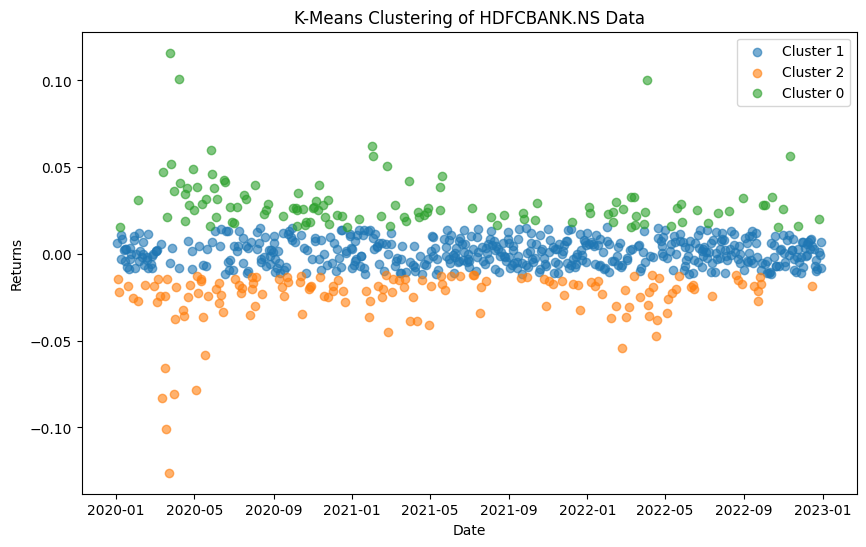

In [40]:
a = MAnalysis('HDFCBANK.NS')
a.emotional_checkup()